In [21]:
import re

In [22]:
with open('./data/kaijin_nijumenso.txt',mode="r",encoding="utf-8") as f:
  text_original = f.read()

text = re.sub('《[^》]+》','',text_original)
text = re.sub('[[^]]+]','',text)
text = re.sub('[｜　]','',text)
# print(text)
print("文字数: ",len(text))

文字数:  111693


In [23]:
n_rnn = 10
batch_size = 128
epochs = 5
n_mid = 128

In [24]:
import numpy as np

chars = sorted(list(set(text)))
print("文字数(重複なし)",len(chars))
char_indices = {}
for number,char in enumerate(chars):
  char_indices[char] = number
indices_char = {}
for number,char in enumerate(chars):
  char_indices[number] = char

time_chars = []
next_chars = []
for i in range(0,len(text)-n_rnn):
  time_chars.append(text[i:i+n_rnn])
  next_chars.append(text[i+n_rnn])

x = np.zeros((len(time_chars),n_rnn,len(chars)),dtype=np.bool_)
t = np.zeros((len(time_chars),len(chars)),dtype=np.bool_)
for i,t_cs in enumerate(time_chars):
  t[i,char_indices[next_chars[i]]] = 1
  for j,char in enumerate(t_cs):
    x[i,j,char_indices[char]] = 1

print("xの形状",x.shape)
print("tの形状",t.shape)

文字数(重複なし) 1257
xの形状 (111683, 10, 1257)
tの形状 (111683, 1257)


In [25]:
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN

In [26]:
model = Sequential()
model.add(SimpleRNN(n_mid,input_shape=(n_rnn,len(chars))))
model.add(Dense(len(chars),activation="softmax"))
model.compile(loss='categorical_crossentropy',optimizer='adam')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 128)               177408    
                                                                 
 dense_2 (Dense)             (None, 1257)              162153    
                                                                 
Total params: 339,561
Trainable params: 339,561
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
from keras.callbacks import LambdaCallback

def on_epoch_end(epoch,logs):
  print("エポック：",epoch)

  beta = 5
  prev_text = text[0:n_rnn]
  created_text = prev_text
  print("シード",created_text)

  for i in range(200):
    x_pred = np.zeros((1,n_rnn,len(chars)))
    for j,char in enumerate(prev_text):
      x_pred[0,j,char_indices[char]] = 1
    
    y = model.predict(x_pred)
    p_power = y[0] ** beta
    next_index = np.random.choice(len(p_power),p=p_power/np.sum(p_power))
    next_char = char_indices[next_index]

    created_text += next_char
    prev_text = prev_text[1:] + next_char

  print(created_text)
  print()

epock_end_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [28]:
history = model.fit(x,t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback],
                    )

Epoch 1/5
871/873 [============================>.] - ETA: 0s - loss: 4.6264エポック： 0
シード そのころ、東京中の町
1/1 [==============================] - 0s 17ms/step
そのころ、東京中の町のにを、これのです。
「いのです。
「のとは、そのです。
「ののは、人のです。
「は、そのです。
「のです。
「のです。
「ののです。
「いのは、そのです。
「ののは、そのです。
「ののです。
「れの、はののののうのです。
「人のです。
「のです。
「れで、いうに、そのです。
「とのは、わののは、そのです。
「のです。
「ののは、そのです。
「のです。
「が、、そのです。
「は、そのです。
「ので

873/873 [==============================] - 27s 31ms/step - loss: 4.6259
Epoch 2/5
871/873 [============================>.] - ETA: 0s - loss: 3.8156エポック： 1
シード そのころ、東京中の町
1/1 [==============================] - 0s 17ms/step
そのころ、東京中の町には、そのです。
「いうのです。
「そのです。
「あいました。
「明智は、そのです。
「このです。
「あいました。
「いい、そのです。
「そのです。
「そのです。」
「そのです。
「それに、そのです。
「あのです。
「あいました。
「あい、そのです。
「いう、このです。
「あったのです。
「こと、そのです。
「いう、おいうに、このです。
「あいました。
「そのです。」
「ありました。
「あり、そん

873/873 [==============================] - 24s 27ms/step - loss: 3.8156
Epoch 3/5
872/873 [============================>.] - ETA: 0s - loss: 3.4641エポック： 2
シード そのころ、東京中の町
1/1 [=============================

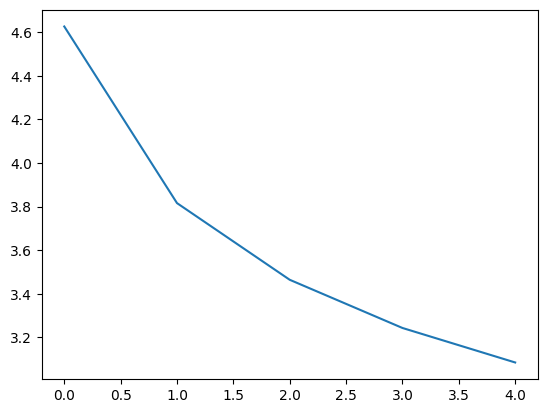

In [30]:
import matplotlib.pyplot as plt

loss = history.history['loss']
plt.plot(np.arange(len(loss)),loss)
plt.show()